In [20]:
import pandas as pd
import warnings
import numpy as np
import optuna
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.mixture import GaussianMixture
from scipy.stats import kstest

warnings.filterwarnings("ignore")

In [4]:
train_data = pd.read_csv('train.csv', header=None)


train_data.head()
y = pd.read_csv('train-target.csv', header=None)
y.rename({0: "target"}, axis = 'columns', inplace=True)
train = pd.concat([train_data, y], axis = 1)
train.columns = train.columns.astype(str)


In [5]:
test = pd.read_csv('test.csv', header=None)
test.columns = test.columns.astype(str)
train.columns = train.columns.astype(str)


In [10]:
train['target'] = train['target'].astype(int)
train_new = train.drop(['9', '15', '16', '17', '22', '26'], axis = 1)
test_new = test.drop(['9', '15', '16', '17', '22', '26'], axis = 1)


In [31]:
from scipy.stats import norm

EM_list = []
for column in train_new.columns:
    pvalue = kstest((train_new[column] - train_new[column].mean())/train_new[column].std(), norm.cdf).pvalue
    if pvalue > 0.05:
        EM_list.append(column)

In [11]:
columns = test_new.columns
test_log = test_new.copy()
for column1 in columns:
    for column2 in columns:
        if column1 != column2:
            test_log[f'{column1}' + '/' + f'{column2}'] = test[column1] / test[column2]
            test_log[f'{column2}' + '/' + f'{column1}'] = test[column2] / test[column1]
            test_log[f'{column1}' + '*' + f'{column2}'] = test[column1] * test[column2]


            
columns = train_new.drop(['target'], axis = 1).columns
train_log = train_new.copy()
for column1 in columns:
    for column2 in columns:
        if column1 != column2:
            train_log[f'{column1}' + '/' + f'{column2}'] = train[column1] / train[column2]
            train_log[f'{column2}' + '/' + f'{column1}'] = train[column2] / train[column1]
            train_log[f'{column1}' + '*' + f'{column2}'] = train[column1] * train[column2]

In [12]:
train_log['max'] = train_new.drop(['target'], axis = 1).max(axis = 1)
test_log['max'] = test_new.max(axis = 1)

train_log['mean'] = train_new.drop(['target'], axis = 1).mean(axis = 1)
test_log['mean'] = test_new.mean(axis = 1)


train_log['min'] = train_new.drop(['target'], axis = 1).min(axis = 1)
test_log['min'] = test_new.min(axis = 1)


train_log['std'] = train_new.drop(['target'], axis = 1).std(axis = 1)
test_log['std'] = test_new.std(axis = 1)

# Model

In [13]:
from sklearn.model_selection import train_test_split

X_tr_, X_val_, y_tr_, y_val_ = train_test_split(train_new.drop(['target'], axis = 1), train_new.target, test_size = 0.2, random_state=42)
X_tr_log_, X_val_log_, _, _ = train_test_split(train_log.drop(['target'], axis = 1), train_log.target, test_size = 0.2, random_state=42)

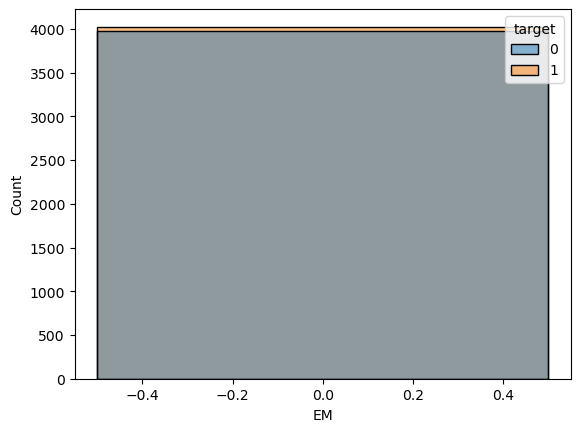

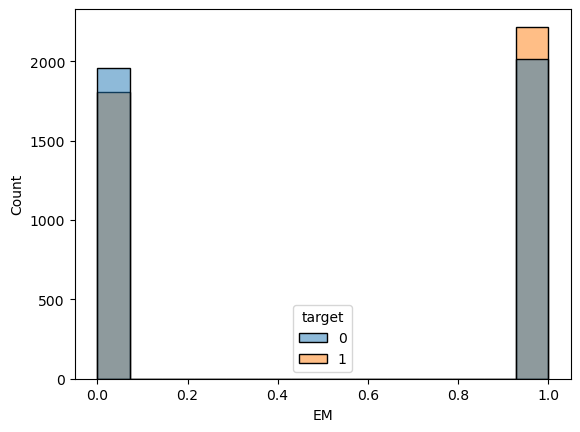

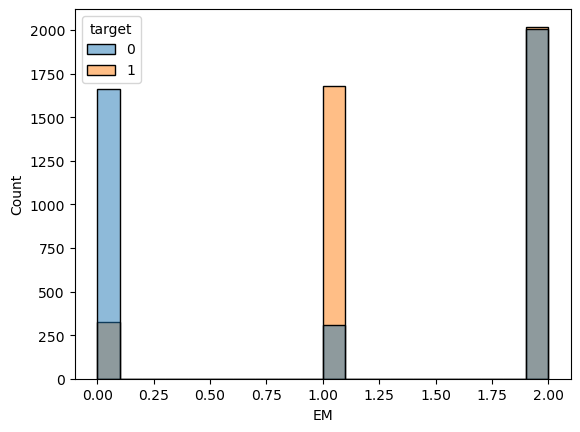

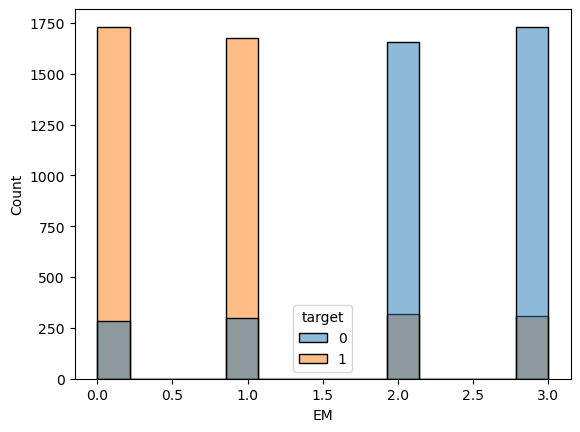

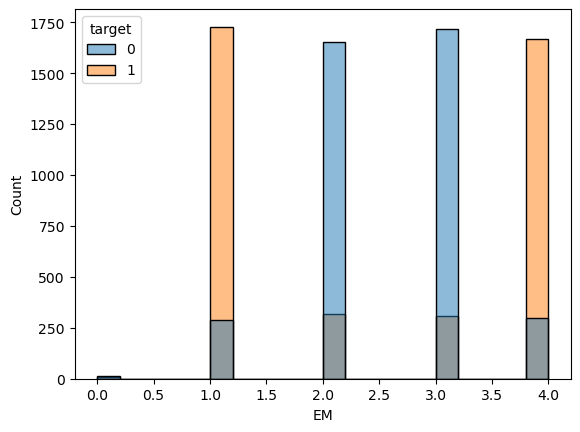

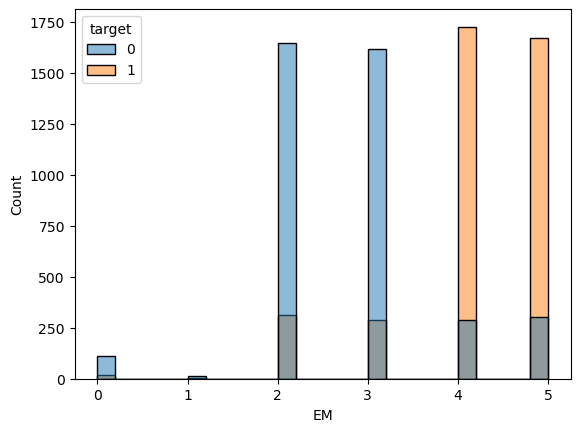

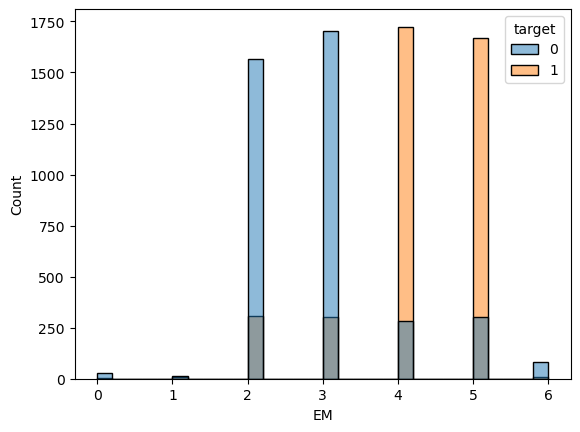

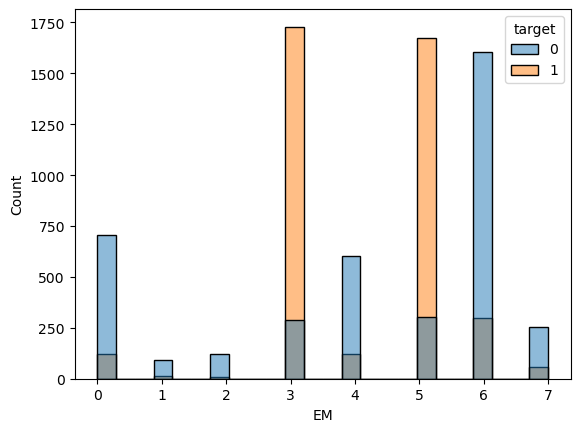

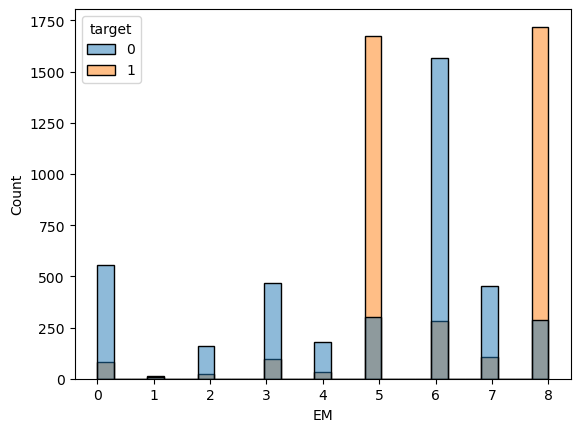

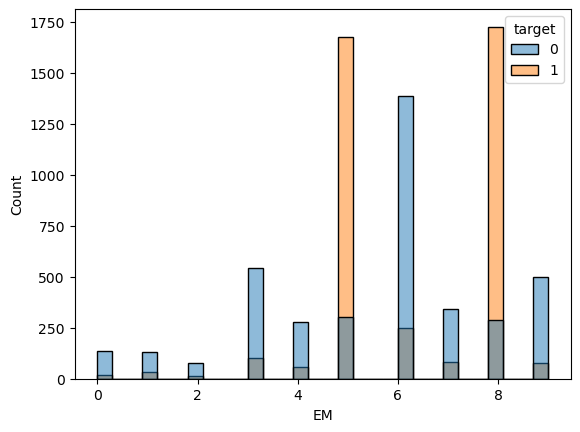

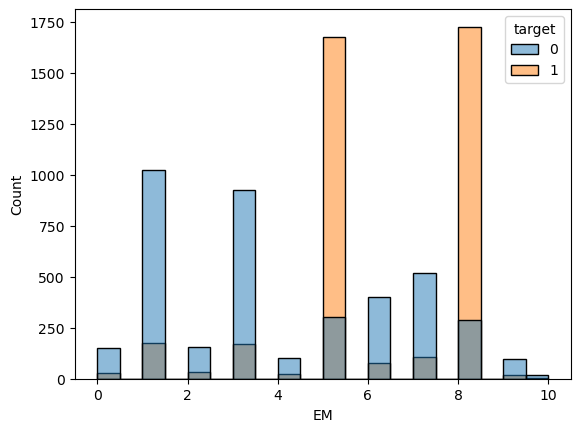

In [42]:
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt

for i in range(1, 12):
    gm = GaussianMixture(n_components=i, random_state=42).fit(X_tr_)

    X_tr_log_['EM'] = gm.predict(X_tr_)
    X_val_log_['EM'] = gm.predict(X_val_)

    sns.histplot(data = X_tr_log_, x = 'EM', hue = y_tr_)
    plt.show()

In [15]:
np.random.seed(42)

In [16]:
params_ = {'objective': 'binary', 
              'metric': 'binary_logloss', 
              'boosting_type': 'dart',
              'eta': 0.5, 
              'max_depth': 10,
              'verbosity': -1, 
              'num_boost_round':400,
              'random_state': 42,
}

In [17]:
params = {'alpha_lgb': 0.4,
 'alpha_svc': 0.9924084605043365,
 'alpha_log': 0.4556810375645594,
 'alpha_knn': 0.9000794018537238,
 'alpha_gauss': 0.038477804016366315,
 'alpha_reg': 0.0061570744023891535,
 'alpha_knn_2': 0.3,
 'alpha_ber': 0.00034246322816774283}

In [18]:
alpha_lgb = params['alpha_lgb']
alpha_svc = params['alpha_svc']
alpha_log = params['alpha_log']
alpha_knn = params['alpha_knn']
alpha_gauss = params['alpha_gauss']
alpha_reg = params['alpha_reg']
alpha_knn_2 = params['alpha_knn_2']
alpha_ber = params['alpha_ber']

In [19]:
dataset = lgb.Dataset(X_tr_log_, y_tr_)
lgb_model = lgb.train(params_, dataset)
y_lgb = lgb_model.predict(X_val_log_)


SVC_model = SVC(C = 0.7, kernel='rbf', random_state = 42, probability = True).fit(X_tr_, y_tr_)
y_SVC = SVC_model.predict_proba(X_val_)[:, 1]


Log_model = LogisticRegression(penalty = 'l1', random_state = 42, solver = 'liblinear').fit(X_tr_log_, y_tr_)
y_log = Log_model.predict_proba(X_val_log_)[:, 1]


knn_model = KNeighborsClassifier(n_neighbors=60, metric = 'cosine',  weights = 'distance').fit(X_tr_, y_tr_)
y_knn = knn_model.predict_proba(X_val_)[:, 1]


knn_model_euc = KNeighborsClassifier(n_neighbors=35, metric = 'euclidean', weights = 'distance').fit(X_tr_, y_tr_)
y_knn_euc = knn_model.predict_proba(X_val_)[:, 1]



y_final = y_knn_euc * alpha_knn_2 + alpha_lgb * y_lgb + alpha_svc * y_SVC + alpha_log * y_log + alpha_knn * y_knn


roc_auc_score(y_val_, y_final)

0.8471056434149484

In [80]:
train_main_ = pd.concat((X_tr_, X_val_))
train_main_log_ = pd.concat((X_tr_log_, X_val_log_))
y_tr_main_ = pd.concat((y_tr_, y_val_))

In [78]:
train_main_log_.shape

(10000, 1133)

In [84]:
dataset = lgb.Dataset(train_main_log_, y_tr_main_)
lgb_model = lgb.train(params_, dataset)
y_lgb = lgb_model.predict(test_log)


SVC_model = SVC(C = 0.7, kernel='rbf', random_state = 42, probability = True).fit(train_main_, y_tr_main_)
y_SVC = SVC_model.predict_proba(test_new)[:, 1]


Log_model = LogisticRegression(penalty = 'l1', random_state = 42, solver = 'liblinear').fit(train_main_log_, y_tr_main_)
y_log = Log_model.predict_proba(test_log)[:, 1]


knn_model = KNeighborsClassifier(n_neighbors=60, metric = 'cosine',  weights = 'distance').fit(train_main_, y_tr_main_)
y_knn = knn_model.predict_proba(test_new)[:, 1]


knn_model_euc = KNeighborsClassifier(n_neighbors=35, metric = 'euclidean', weights = 'distance').fit(train_main_, y_tr_main_)
y_knn_euc = knn_model.predict_proba(test_new)[:, 1]


gauss_model = GaussianNB().fit(train_main_, y_tr_main_)
y_gauss = gauss_model.predict_proba(test_new)[:, 1]


linear_model = LinearRegression().fit(train_main_log_, y_tr_main_)
y_reg = linear_model.predict(test_log)


bernulli_model = BernoulliNB().fit(train_main_log_, y_tr_main_)
y_ber = bernulli_model.predict_proba(test_log)[:, 1]



y_final = y_knn_euc * alpha_knn_2 + alpha_lgb * y_lgb + alpha_svc * y_SVC + alpha_log * y_log + alpha_knn * y_knn + alpha_gauss * y_gauss + y_reg  * alpha_reg + alpha_ber * y_ber


roc_auc_score(y_val_, y_final)

0.5093062910527517

?????????????????

In [85]:
df_subm = pd.DataFrame({'y': y_final})

In [86]:
name = 'ensembley_0.85_full_dataset'
df_subm.to_csv(f'{name}.csv', index=False, header=False)